# Recovery of the coefficients of a polynomial

We aim to recover the polynomial $p(x)=7x^{10}+4x^{33}+2x^{60}+8x^{99}$ by evaluating it in less than $99$ points using compressed sensing techniques. In particular we will use $\ell_1$ minimization and the CoSaMP algorithm https://arxiv.org/pdf/0803.2392.pdf .

In [41]:
"""Raquel García Bellés
Bachelor's degree in Mathematics
Universitat Autònoma de Barcelona
Final project - Beating the Nyquist-Shannon theorem with randomness: the magic of compressed sensing.
Last update: 24/05/2021"""

from numpy import random
import scipy as sc
from numpy.linalg import pinv
import numpy as np
import matplotlib.pyplot as plt
from random import sample
import cmath
from random import uniform

def cosamp(phi, u, s, epsilon=1e-10, max_iter=1000):
    """
    Return an `s`-sparse approximation of the target signal
    Input:
        - phi, sampling matrix
        - u, noisy sample vector
        - s, sparsity
    """
    a = np.zeros(phi.shape[1])
    v = u
    it = 0 # count
    halt = False
    while not halt:
        it += 1
        print("Iteration {}\r".format(it), end="")
        
        y = np.dot(np.transpose(phi), v)
        omega = np.argsort(y)[-(2*s):] # large components
        omega = np.union1d(omega, a.nonzero()[0]) # use set instead?
        phiT = phi[:, omega]
        b = np.zeros(phi.shape[1])
        # Solve Least Square
        b[omega], _, _, _ = np.linalg.lstsq(phiT, u)
        
        # Get new estimate
        b[np.argsort(b)[:-s]] = 0
        a = b
        
        # Halt criterion
        v_old = v
        v = u - np.dot(phi, a)

        halt = (np.linalg.norm(v - v_old) < epsilon) or \
            np.linalg.norm(v) < epsilon or \
            it > max_iter
        
    return a



get_delta_1 = lambda A: 1-np.linalg.eigvalsh(np.conjugate(A.transpose())@A)[0]
get_delta_2 = lambda A: np.linalg.eigvalsh(np.conjugate(A.transpose())@A)[-1]-1
def estimate_RIP(A, klist, trials):
    delta_1 = []
    delta_2 = [] 
    for k in klist:
        delta_1_trial = []
        delta_2_trial = []
        for i in range(0,trials):
            # we sample k columns of the A matrix
            q = random.permutation(n)
            sample = q[:k]
            A_sampled = A[:,sample]
            delta_1_trial.append(get_delta_1(A_sampled))
            delta_2_trial.append(get_delta_2(A_sampled))
        delta_1.append(np.max(delta_1_trial))
        delta_2.append(np.max(delta_2_trial))
    
    #delta = np.maximum(delta_1,delta_2)
    return delta_1, delta_2

Text(0, 0.5, 'p(x)')

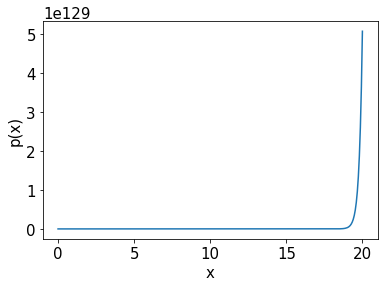

In [48]:
# We store the coefficients of the polynomial in an array
# The dimension of the full signal is the total degree of the polynomial +1
n = 100
a = np.zeros(n);
a[10] = 7;
a[33] = 4;
a[60] = 2;
a[99] = 8;
low = 0
high = 20
a = a.transpose()
x = np.linspace(low,high,300);
p = a[10]*x**10 + a[33]*x**33 + a[60]*x**60 + a[99]*x**99;

plt.plot(x,p)
plt.xlabel('x')
plt.ylabel('p(x)')

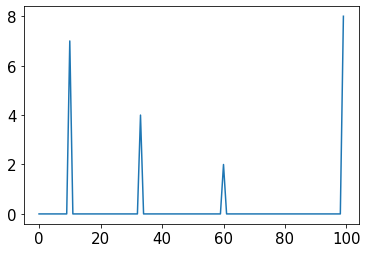

In [49]:
plt.plot(a) # array of coefficients, it is a sparse signal

First we construct the sensing matrix so that taking the samples is equivalent to evaluating the polynomial in $m$ roots of unity chosen uniformly at random.

In [57]:
m = 30
A = np.zeros((m,n), dtype=complex)
r = []
u = sample(list(np.arange(n)+1),m)
for i in range(0,m):
    for j in range(0,n):
        A[i,j]=cmath.exp(1J*2*np.pi*u[i]*j/n)/np.sqrt(n)

Just for reference we estimate the RIP constant of this sensing matrix.

In [58]:
k_max = 21
klist = np.arange(1,k_max)

trials = 2000
delta_1, delta_2 = estimate_RIP(A, klist, trials)

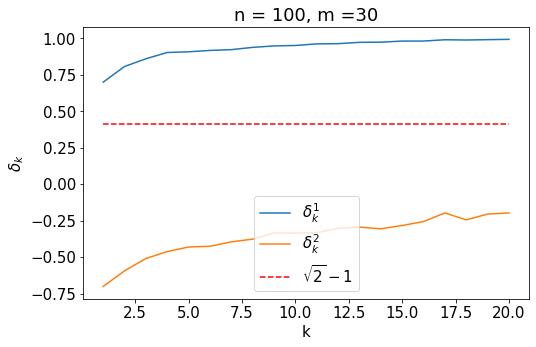

In [59]:
plt.figure(figsize = (8,5))
plt.plot(klist,delta_1,label='$\delta_k^1$' )
plt.plot(klist,delta_2,label ='$\delta_k^2$')
#plt.plot(klist,delta)
plt.plot(klist,np.zeros(len(klist))+np.sqrt(2)-1, 'r--',label = '$\sqrt{2}-1$')
plt.xlabel('k')
plt.ylabel('$\delta_k$')
plt.title('n = %u, m =%u' %(n,m) )
plt.legend()

Now we take the samples:

In [60]:
y = A@a

The samples and the sensing matrix contain complex numbers, hence we have to separate the real and the imaginary part in order for the optimization algorithms to work well.

In [61]:
Y = np.concatenate((np.real(y),np.imag(y))) # new set of samples

AA = np.concatenate((np.real(A), np.imag(A)))
BB = np.concatenate((-np.imag(A), np.real(A)))
AAA = np.concatenate((AA,BB), axis = 1) # new sensing matrix

Also for reference we estimate the RIP of AAA

In [62]:
k_max = 21
klist = np.arange(1,k_max)

trials = 2000
delta_1, delta_2 = estimate_RIP(AAA, klist, trials)

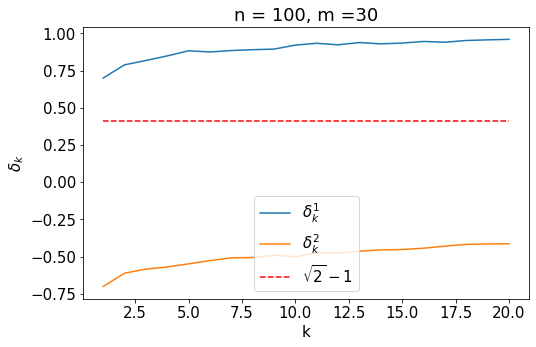

In [63]:
plt.figure(figsize = (8,5))
plt.plot(klist,delta_1,label='$\delta_k^1$' )
plt.plot(klist,delta_2,label ='$\delta_k^2$')
#plt.plot(klist,delta)
plt.plot(klist,np.zeros(len(klist))+np.sqrt(2)-1, 'r--',label = '$\sqrt{2}-1$')
plt.xlabel('k')
plt.ylabel('$\delta_k$')
plt.title('n = %u, m =%u' %(n,m) )
plt.legend()

Now we execute the recovey via cosamp:

C:\Users\raque\Miniconda3\lib\site-packages\ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


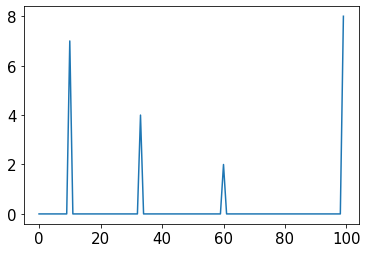

In [64]:
reco = cosamp(AAA, Y, 4, epsilon=1e-10, max_iter=1000)
plt.plot(reco[:100])

Now we use $\ell_1$ minimization

In [8]:
from scipy.optimize import minimize
def L1_norm(x):
    return np.linalg.norm(x,ord=1)

constr = ({'type': 'eq', 'fun': lambda x:  AAA@x - Y}) # equality constraint function must be zero
x0 = np.linalg.pinv(AAA)@Y #initial guess
res = minimize(L1_norm, x0, method='SLSQP',constraints=constr)
s = res.x

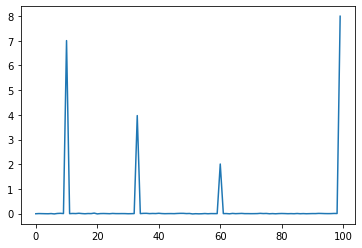

In [9]:
plt.plot(s[:100])

We have seen that both $\ell_1$ minimization and CoSaMP work well for $m=30$ samples. Now we will compare their performance for different number of samples.

In [10]:
error_l1 = []
error_cosamp = []
a_exact = np.concatenate((np.real(a),np.imag(a)))
for m in range(1,n):
    A = np.zeros((m,n), dtype = complex)
    r = []
    u = sample(list(np.arange(n)+1),m)
    for i in range(0,m):
        for j in range(0,n):
            A[i,j]=cmath.exp(1J*2*np.pi*u[i]*j/n)
    y = A@a
    
    Y = np.concatenate((np.real(y),np.imag(y))) # new set of samples

    AA = np.concatenate((np.real(A), np.imag(A)))
    BB = np.concatenate((-np.imag(A), np.real(A)))
    AAA = np.concatenate((AA,BB), axis = 1) # new sensing matrix
    
    # Cosamp
    reco = cosamp(AAA, Y, 4, epsilon=1e-10, max_iter=1000)
    error_cosamp.append(np.sum(np.abs(np.subtract(a_exact,reco)))) #absolut error
    
    # l1
    constr = ({'type': 'eq', 'fun': lambda x:  AAA@x - Y}) # equality constraint function must be zero
    x0 = np.linalg.pinv(AAA)@Y #initial guess
    res = minimize(L1_norm, x0, method='SLSQP',constraints=constr)
    s = res.x
    error_l1.append(np.sum(np.abs(np.subtract(a_exact,s))))

C:\Users\raque\Miniconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


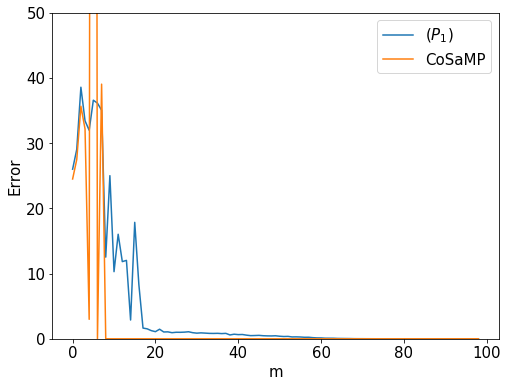

In [12]:
plt.figure(figsize = (8,6))

plt.plot(error_l1, label = r'$(P_1)$')
plt.plot(error_cosamp, label = 'CoSaMP')
plt.ylabel('Error')
plt.xlabel('m')
plt.rcParams.update({'font.size': 15})
plt.ylim((0,50))
plt.legend()
plt.savefig('polynomial.eps',bbox_inches='tight')

From 9 samples the error using cosamp is 0.

From 17 samples the error using l1 minimization is 0.

error_l1 = [25.99966208346696,
 29.043991266619678,
 38.56700257101399,
 33.40748113303019,
 31.96994016163897,
 36.578146685140126,
 36.12390879211017,
 35.04209008730279,
 12.519651880591955,
 25.00899021149808,
 10.289766829991889,
 16.02671886991609,
 11.832504556565864,
 12.019980303351568,
 2.8799548631468443,
 17.851746235326424,
 8.29540006544445,
 1.6432008402843101,
 1.529587309031995,
 1.2506314611916762,
 1.0945164390346114,
 1.4692259285636728,
 1.0456181701662723,
 1.0651319153475154,
 0.9374046449363256,
 1.001734961081018,
 0.9957313486123003,
 1.0207053378392477,
 1.0797234234170283,
 0.9375586181493032,
 0.8659765835075499,
 0.9094769424438558,
 0.8719392552324091,
 0.8319951723847805,
 0.8224153279781866,
 0.8391684384578438,
 0.7987003177949988,
 0.8329800571409103,
 0.5912994540293454,
 0.7036921458617815,
 0.6404144374855931,
 0.6594497298806397,
 0.5576520758591401,
 0.4852728440268302,
 0.5021783583618717,
 0.5258787935972933,
 0.4725526409192873,
 0.4483276506657218,
 0.4379669403181132,
 0.46264644538278477,
 0.3934893579301121,
 0.3510365615161235,
 0.37059322529544314,
 0.28615863535661296,
 0.2967709173748158,
 0.27450706237163197,
 0.2341377315690846,
 0.23680076827122576,
 0.17500640664583414,
 0.13770501487296705,
 0.13236813041384066,
 0.09095446305982097,
 0.08782362560441206,
 0.08283990719727771,
 0.05531980321581166,
 0.049054284960011664,
 0.041303378858094805,
 0.034488025094986996,
 0.021478041210260257,
 0.016424101457025036,
 0.016541216163981336,
 0.011522718910076156,
 0.00943290331525159,
 0.0075437762760010695,
 0.007443237158208742,
 0.0036122611871868683,
 0.0033775444561827536,
 0.004150918265305956,
 0.0026290654980517057,
 0.0022019503180934806,
 0.0013815928259890047,
 0.0011277611244335994,
 0.0006021430770194164,
 0.0003747215546832533,
 0.00018052911444792533,
 0.00010510849106354346,
 5.1071506329247436e-05,
 2.6871948599129223e-05,
 1.6855788703975953e-05,
 1.5184586837459205e-05,
 1.3164664726523938e-05,
 1.2186710246910216e-05,
 1.56816163212386e-05,
 1.3395401283890131e-05,
 1.1587320195143362e-05,
 8.617209703795597e-06,
 7.894722693925782e-06,
 1.5910003310854434e-05,
 4.066537516951931e-06]

error_cosamp = [24.497870284442094,
 27.48394287040844,
 35.64688389562883,
 32.15816401924458,
 2.985221938825307,
 439.25912358205164,
 2.3092638912203256e-14,
 39.0359255133005,
 8.215650382226158e-15,
 2.220446049250313e-14,
 1.509903313490213e-14,
 4.8405723873656825e-14,
 4.707345624410664e-14,
 1.8207657603852567e-14,
 2.0650148258027912e-14,
 3.9968028886505635e-15,
 1.1324274851176597e-14,
 6.439293542825908e-15,
 3.552713678800501e-15,
 1.2434497875801753e-14,
 3.552713678800501e-15,
 2.042810365310288e-14,
 9.325873406851315e-15,
 1.3100631690576847e-14,
 1.1102230246251565e-14,
 7.771561172376096e-15,
 1.021405182655144e-14,
 2.8199664825478976e-14,
 1.8207657603852567e-14,
 1.1324274851176597e-14,
 2.398081733190338e-14,
 1.1546319456101628e-14,
 3.3306690738754696e-14,
 7.549516567451064e-15,
 6.217248937900877e-15,
 1.199040866595169e-14,
 1.1102230246251565e-14,
 1.7763568394002505e-14,
 7.549516567451064e-15,
 3.1530333899354446e-14,
 1.3100631690576847e-14,
 1.865174681370263e-14,
 1.1546319456101628e-14,
 1.0880185641326534e-14,
 7.993605777301127e-15,
 1.199040866595169e-14,
 1.021405182655144e-14,
 1.9317880628477724e-14,
 7.993605777301127e-15,
 1.4210854715202004e-14,
 6.661338147750939e-15,
 7.549516567451064e-15,
 5.995204332975845e-14,
 9.103828801926284e-15,
 1.865174681370263e-14,
 5.551115123125783e-15,
 5.551115123125783e-15,
 1.3766765505351941e-14,
 2.7977620220553945e-14,
 6.661338147750939e-15,
 5.10702591327572e-15,
 1.4210854715202004e-14,
 1.1324274851176597e-14,
 7.993605777301127e-15,
 1.0436096431476471e-14,
 1.84297022087776e-14,
 8.881784197001252e-15,
 1.021405182655144e-14,
 1.7319479184152442e-14,
 1.2656542480726785e-14,
 1.0658141036401503e-14,
 1.8207657603852567e-14,
 7.105427357601002e-15,
 2.3092638912203256e-14,
 7.549516567451064e-15,
 1.199040866595169e-14,
 8.881784197001252e-15,
 1.7319479184152442e-14,
 1.509903313490213e-14,
 2.886579864025407e-14,
 1.3988810110276972e-14,
 2.0872192862952943e-14,
 1.2878587085651816e-14,
 1.4876988529977098e-14,
 1.4876988529977098e-14,
 1.3766765505351941e-14,
 2.220446049250313e-14,
 2.1538326677728037e-14,
 7.549516567451064e-15,
 1.7319479184152442e-14,
 7.105427357601002e-15,
 8.215650382226158e-15,
 8.881784197001252e-15,
 5.329070518200751e-15,
 1.6431300764452317e-14,
 7.815970093361102e-14,
 6.217248937900877e-15,
 1.1546319456101628e-14,
 2.4646951146678475e-14]